In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from absl import flags

In [2]:
## Relative imports
from dataHandler.dataset import MHDProjDataset,LogNormalTransform

from ddpm.model import UNet
from ddpm.diffusion import DDPM, generate_image

from validationMetrics.powerSpectrum import power_spectrum_iso, plot_ps
from validationMetrics.minkowskiFunctional import plot_mink_functionals

from utils.plot import plot_epoch, check_epoch_nearest_sample, plot_and_save_line, plot_comparaison_1channel, plot_comparaison_multi_channel

In [3]:
MODEL_ID = 'PLANCKN_DDPM_skip_GN_bottleneck16_epochs10000_dim2'
MODEL_ID = 'MHD_SigmaDDPM_test3'
CKPT_FOLDER = '/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps/' #For checkpoints and losses

In [4]:
FLAGS=flags.FLAGS
for name in list(flags.FLAGS):
  delattr(flags.FLAGS, name)

In [5]:
try:
    flags.DEFINE_string('model_id','MHD_DDPM_forget',help= 'ID of the model either trained, finetuned, evaluated....')

    ## Data & transforms
    flags.DEFINE_string('source_dir','/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj',help= 'Source dir containing a list of npy files')
    flags.DEFINE_bool('random_rotate', True, help='')
    flags.DEFINE_bool('no_lognorm', False, help='apply a lognormal transformation to the dataset')

    ## Network & diffusion parameters

    flags.DEFINE_enum('diffusion_mode', 'ddpm', ['ddpm', 'smld', 'VE', 'VD', 'sub_VP', 'SigmaDDPM'], help='Type of diffusion SDE used during training and inference')
    ## TODO if we want to fully use the SDE/ score based framework (and have custom/off the shelf SDE solvers, we will nedd to use runners/differentiate the training loop)
    # For DDPM
    flags.DEFINE_integer('n_steps', 1000, help= 'Diffusion total time see Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')
    flags.DEFINE_float('beta_start', 1e-4, help = 'Beta at time 0 see Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')
    flags.DEFINE_float('beta_T',0.02, help= 'Beta at time T=n_steps Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')

    #Unet
    flags.DEFINE_enum('network', 'unet', ['unet', 'ResUNet'], help='DUNet not yet implemented')
    flags.DEFINE_integer('size',256, help='height and width of the images')
    flags.DEFINE_integer('in_channel', 1, help= 'number of channel on input and output images')
    flags.DEFINE_enum('normalization', 'LN' , ['LN' , 'default', 'LN-D', 'LN-F', 'LN-F+', 'LN-DF', 'BN', 'BN/LN', 'BN/FLN', 'BN/F+LN', 'DBN/LN', 'GN', 'DN','None'], help= 'type of normalization applied') ## TODO upcoming cleaning of these options based on elimination and perceived redundancies
    flags.DEFINE_float('eps_norm', 1e-5, help= 'epsilon value added to the variance in the normalization layer to ensure numerical stability')
    flags.DEFINE_integer('size_min', 32, help= 'size at the bottleneck')
    flags.DEFINE_integer('num_blocks', 1, help= 'num of blocks per size on descent')
    flags.DEFINE_enum('padding_mode', 'circular' ,['zeros', 'reflect', 'replicate','circular'], help='Conv2d padding mode')
    flags.DEFINE_bool('muP', False, help= 'Use mu Parametrisation for initialisation and training') ## TODO 
    flags.DEFINE_float('dropout', 0, help= 'Probability for dropout, we did not find any impact because our models tend not to overfit')
    flags.DEFINE_integer('first_c_mult', 10, help= 'Multiplier between in_c and out_c for the first block')
    flags.DEFINE_bool('skip_rescale', False, help='Rescale skip connections (see Score Based Generative Modelling paper)')

    ## Training parameters 
    flags.DEFINE_integer('batch_size', 64, help='Dataloader batch size')
    flags.DEFINE_integer('num_sample', 8, help='Number of sample for an epoch in the middle')
    flags.DEFINE_integer('num_result_sample', 256, help='Number of sample for an epoch in the middle')
    flags.DEFINE_float('lr', 1e-3, help= 'Learning rate')
    flags.DEFINE_enum('lr_scheduler', 'None', ['None','stepLR'], help='scheduler, if any used in training')
    flags.DEFINE_integer('warmup', 100, help='Length of warmup, if 0 then no warmup')
    flags.DEFINE_integer('test_set_len', 95, help='')
    flags.DEFINE_integer('num_epochs', 500, help='Number of epochs')
    flags.DEFINE_enum('optimizer', 'Adam', ['AdamW', 'Adam', 'MoMo'], help='MoMo not implemented in particular for now') ## TODO MoMo 
    flags.DEFINE_float('weight_decay', 0.0, help= 'Weight decay hyper parameter')
    flags.DEFINE_float('ema', 0.0, help='Exponentially moving average momentum, if 0 then no ema applied NOT IMPLEMENTED yet ')  ## TODO

    ## Sampling and checkpointing
    flags.DEFINE_integer('save_step_epoch', 100, help='Period in nb of epochs for saving ckpt & losses')
    flags.DEFINE_integer('sample_step_epoch', 100, help='Period in nb of epoch for generating a few npy samples')
    flags.DEFINE_string('sample_folder','/mnt/home/dheurtel/ceph/20_samples/artificial_architecture_exps',help= 'directory where generated samples (in the middle of training) or results are stored')
    flags.DEFINE_string('ckpt_folder','/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps',help= 'Directory for ckpt & loss storage (as well as some training specs)')


except:
    print("Flags already defined but you can still re-parse them with next few cells")

In [6]:
def extract_flag_name(str):
    pref='--'
    suff='='
    try:
        idx1 = str.index(pref)
        idx2 = str.index(suff)
    except:
        try:
            idx1 = str.index(pref)
            idx2=len(str)
        except:
            return None
    return str[idx1 + len(pref): idx2]


In [7]:
with open(os.path.join(CKPT_FOLDER, MODEL_ID, 'flagfile.txt')) as f:
    lines = f.read().splitlines()

lines=[s for s in lines if (extract_flag_name(s) in FLAGS) or (extract_flag_name(s)[2:] in FLAGS and extract_flag_name(s)[:2]=='no')]

FLAGS(lines)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps/MHD_SigmaDDPM_test3/flagfile.txt'

In [10]:
SOURCE_DIR=FLAGS.source_dir

SAMPLE_FOLDER=FLAGS.sample_folder


SIZE=FLAGS.size

N_STEPS=FLAGS.n_steps
BATCH_SIZE=FLAGS.batch_size
SAMPLE_BATCH_SIZE=FLAGS.num_sample
RESULT_SAMPLE_SIZE=FLAGS.num_result_sample

SAVE_STEP_EPOCH=FLAGS.save_step_epoch
SAMPLE_STEP_EPOCH=FLAGS.sample_step_epoch

NUM_EPOCHS=FLAGS.num_epochs
LR=FLAGS.lr

NUM_CHANNEL = FLAGS.in_channel

if FLAGS.no_lognorm:
    transforms = None
else:
    transforms = LogNormalTransform()  

UnparsedFlagAccessError: Trying to access flag --source_dir before flags were parsed.

In [14]:
dataset=MHDProjDataset(SOURCE_DIR,random_rotate=FLAGS.random_rotate,transforms=transforms,test_batch_length=FLAGS.test_set_len)

In [15]:
amin,amax=(-6.232629, 7.390278)

**Results Visualisation**

In [18]:
l=os.listdir(os.path.join(SAMPLE_FOLDER,MODEL_ID))
l.sort()

l_results=l[:RESULT_SAMPLE_SIZE]
l_samples=l[RESULT_SAMPLE_SIZE:]

n_epoch_sampled=len(l_samples)//SAMPLE_BATCH_SIZE

In [24]:
n_epoch_sampled

10

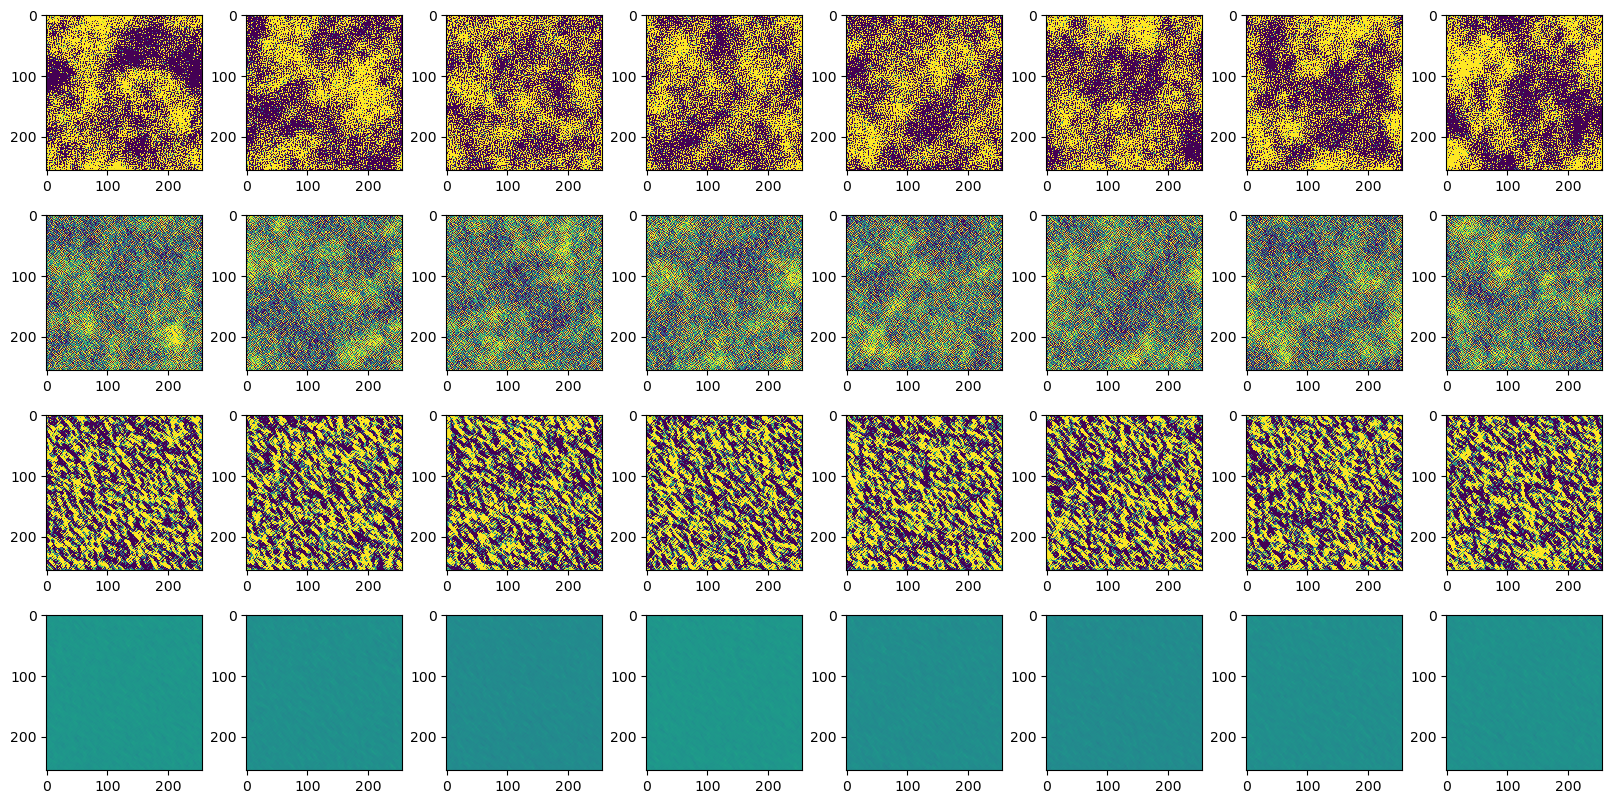

In [23]:
fig, ax =plt.subplots(4,8,figsize=(16, 8), layout="constrained")

for i in range(8):
    ax[0,i].imshow(np.sum(np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID,l_samples[i]),allow_pickle=True),axis=0),vmin=amin,vmax=amax) ##axis sum because of shape 1,
for i in range(8):
    ax[1,i].imshow(np.sum(np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID,l_samples[n_epoch_sampled//10*8+i]),allow_pickle=True),axis=0),vmin=amin,vmax=amax) 
for i in range(8):
    ax[2,i].imshow(np.sum(np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID,l_samples[n_epoch_sampled//2*8+i]),allow_pickle=True),axis=0),vmin=amin,vmax=amax) 
for i in range(8):
    ax[3,i].imshow(np.sum(np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID,l_results[i]),allow_pickle=True),axis=0),vmin=amin,vmax=amax) 

In [20]:
check_epoch_nearest_sample(499, SAMPLE_STEP_EPOCH, SAMPLE_FOLDER, MODEL_ID, l_samples, amin, amax, num_samples_per_sampling_epoch=FLAGS.num_sample, num_plot=6)

UnparsedFlagAccessError: Trying to access flag --num_sample before flags were parsed.

In [8]:
start=0

In [9]:
samples_reduced = [np.sum(np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID,l_results[start+col]),allow_pickle=True),axis=0) for col in range(5)]
samples = [np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID,l_results[start+col]),allow_pickle=True) for col in range(5)]

plot_and_save_line(samples_reduced, amin, amax ,save_file = None,figsize = (48, 20)) #savefile = '/_pdf/results_'+MODEL_ID+'_'+str(start//5)+'.pdf'

NameError: name 'SAMPLE_FOLDER' is not defined

**Comparison**

Shape is probably wrong. Here is what a 1 channel comparaison would give you


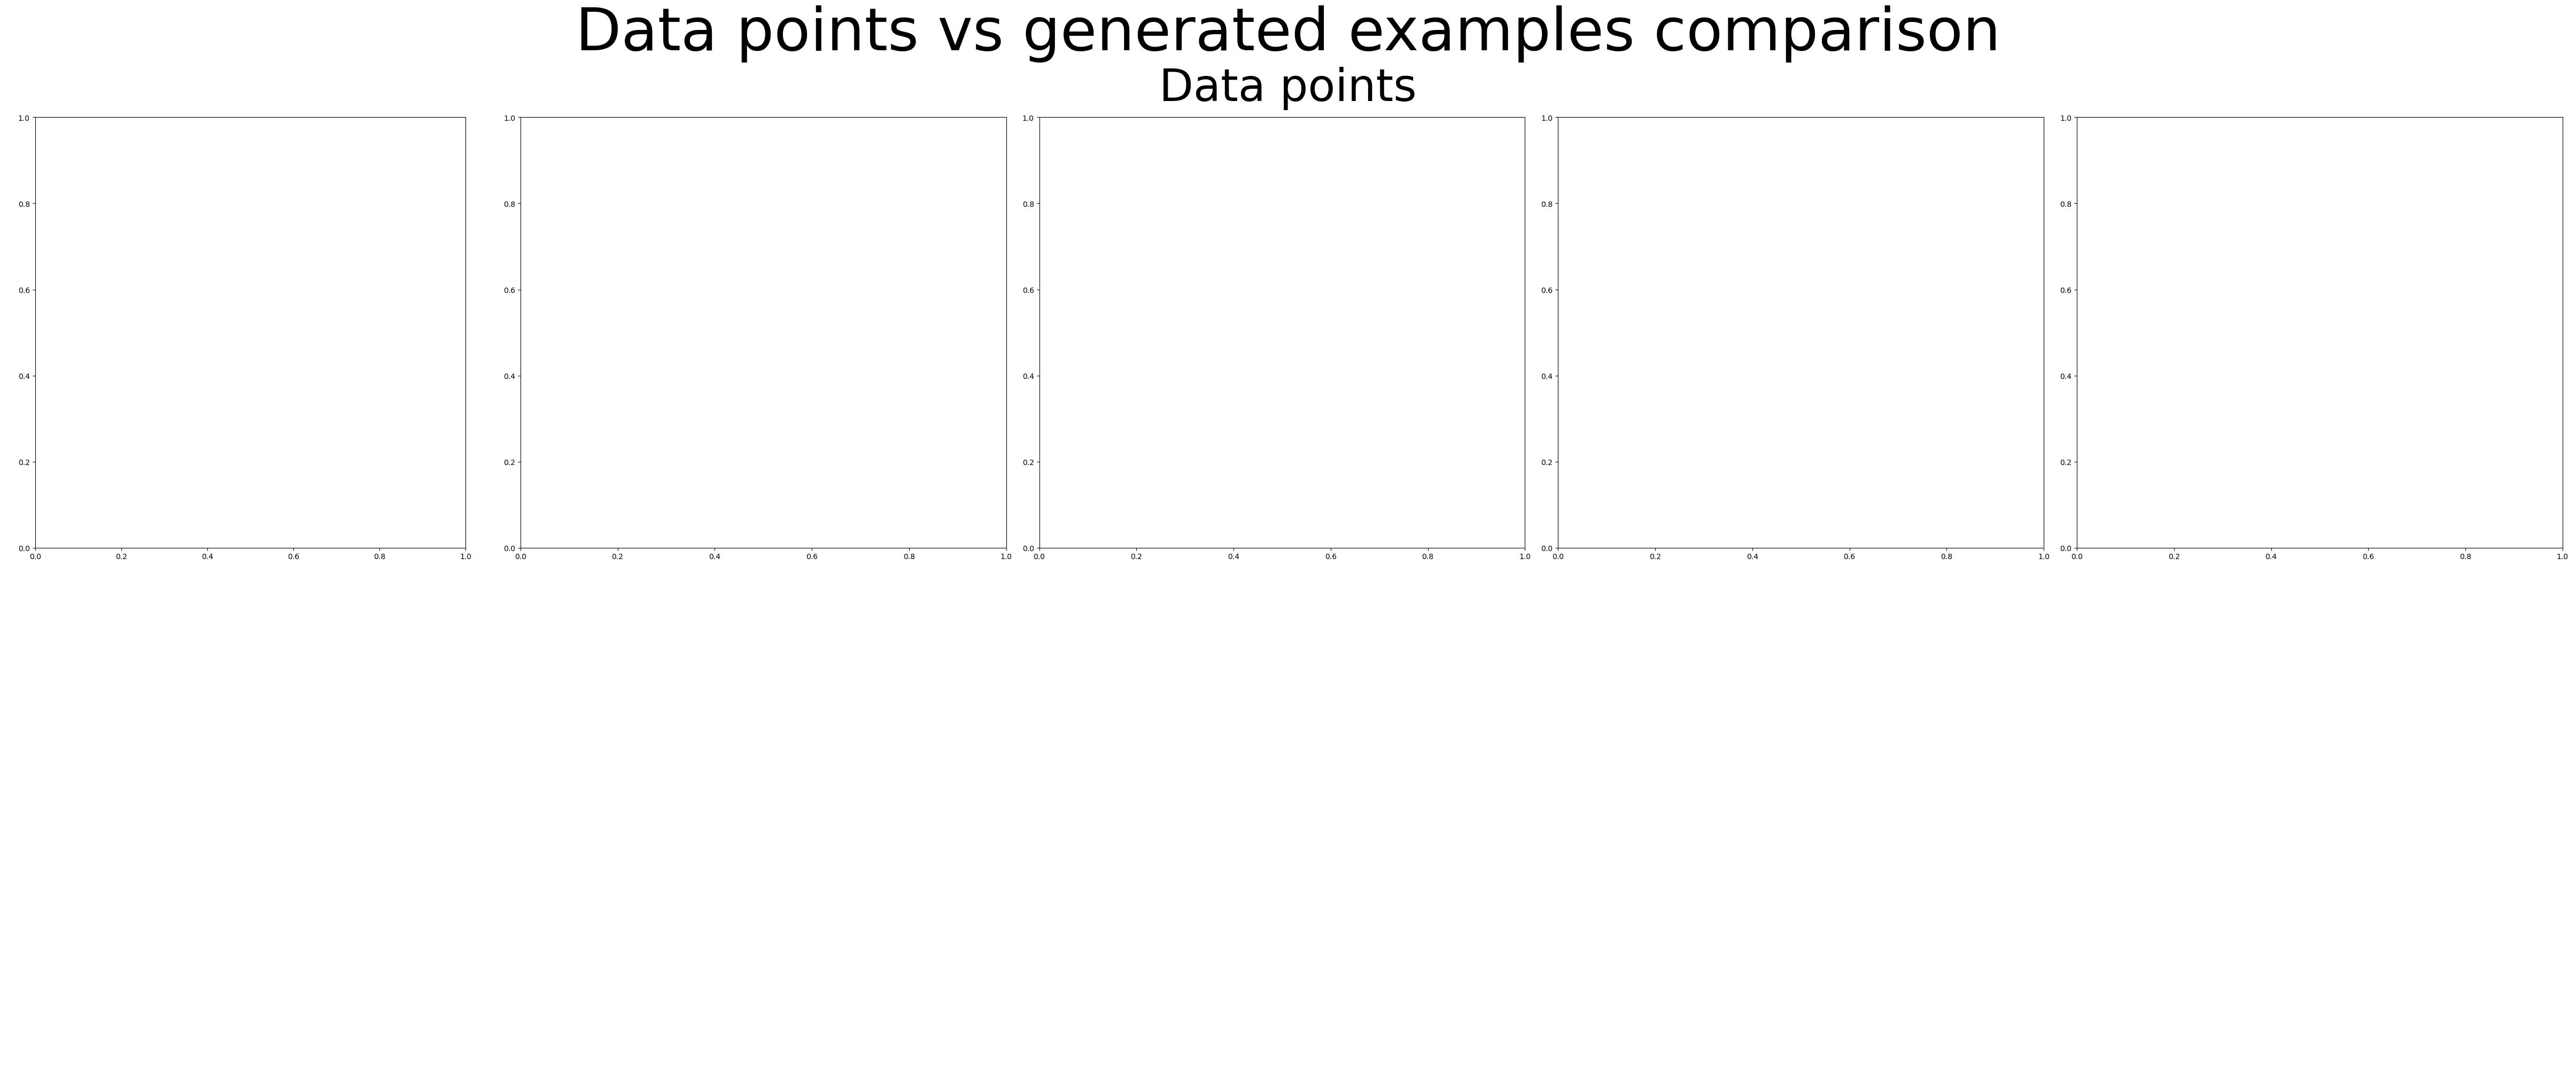

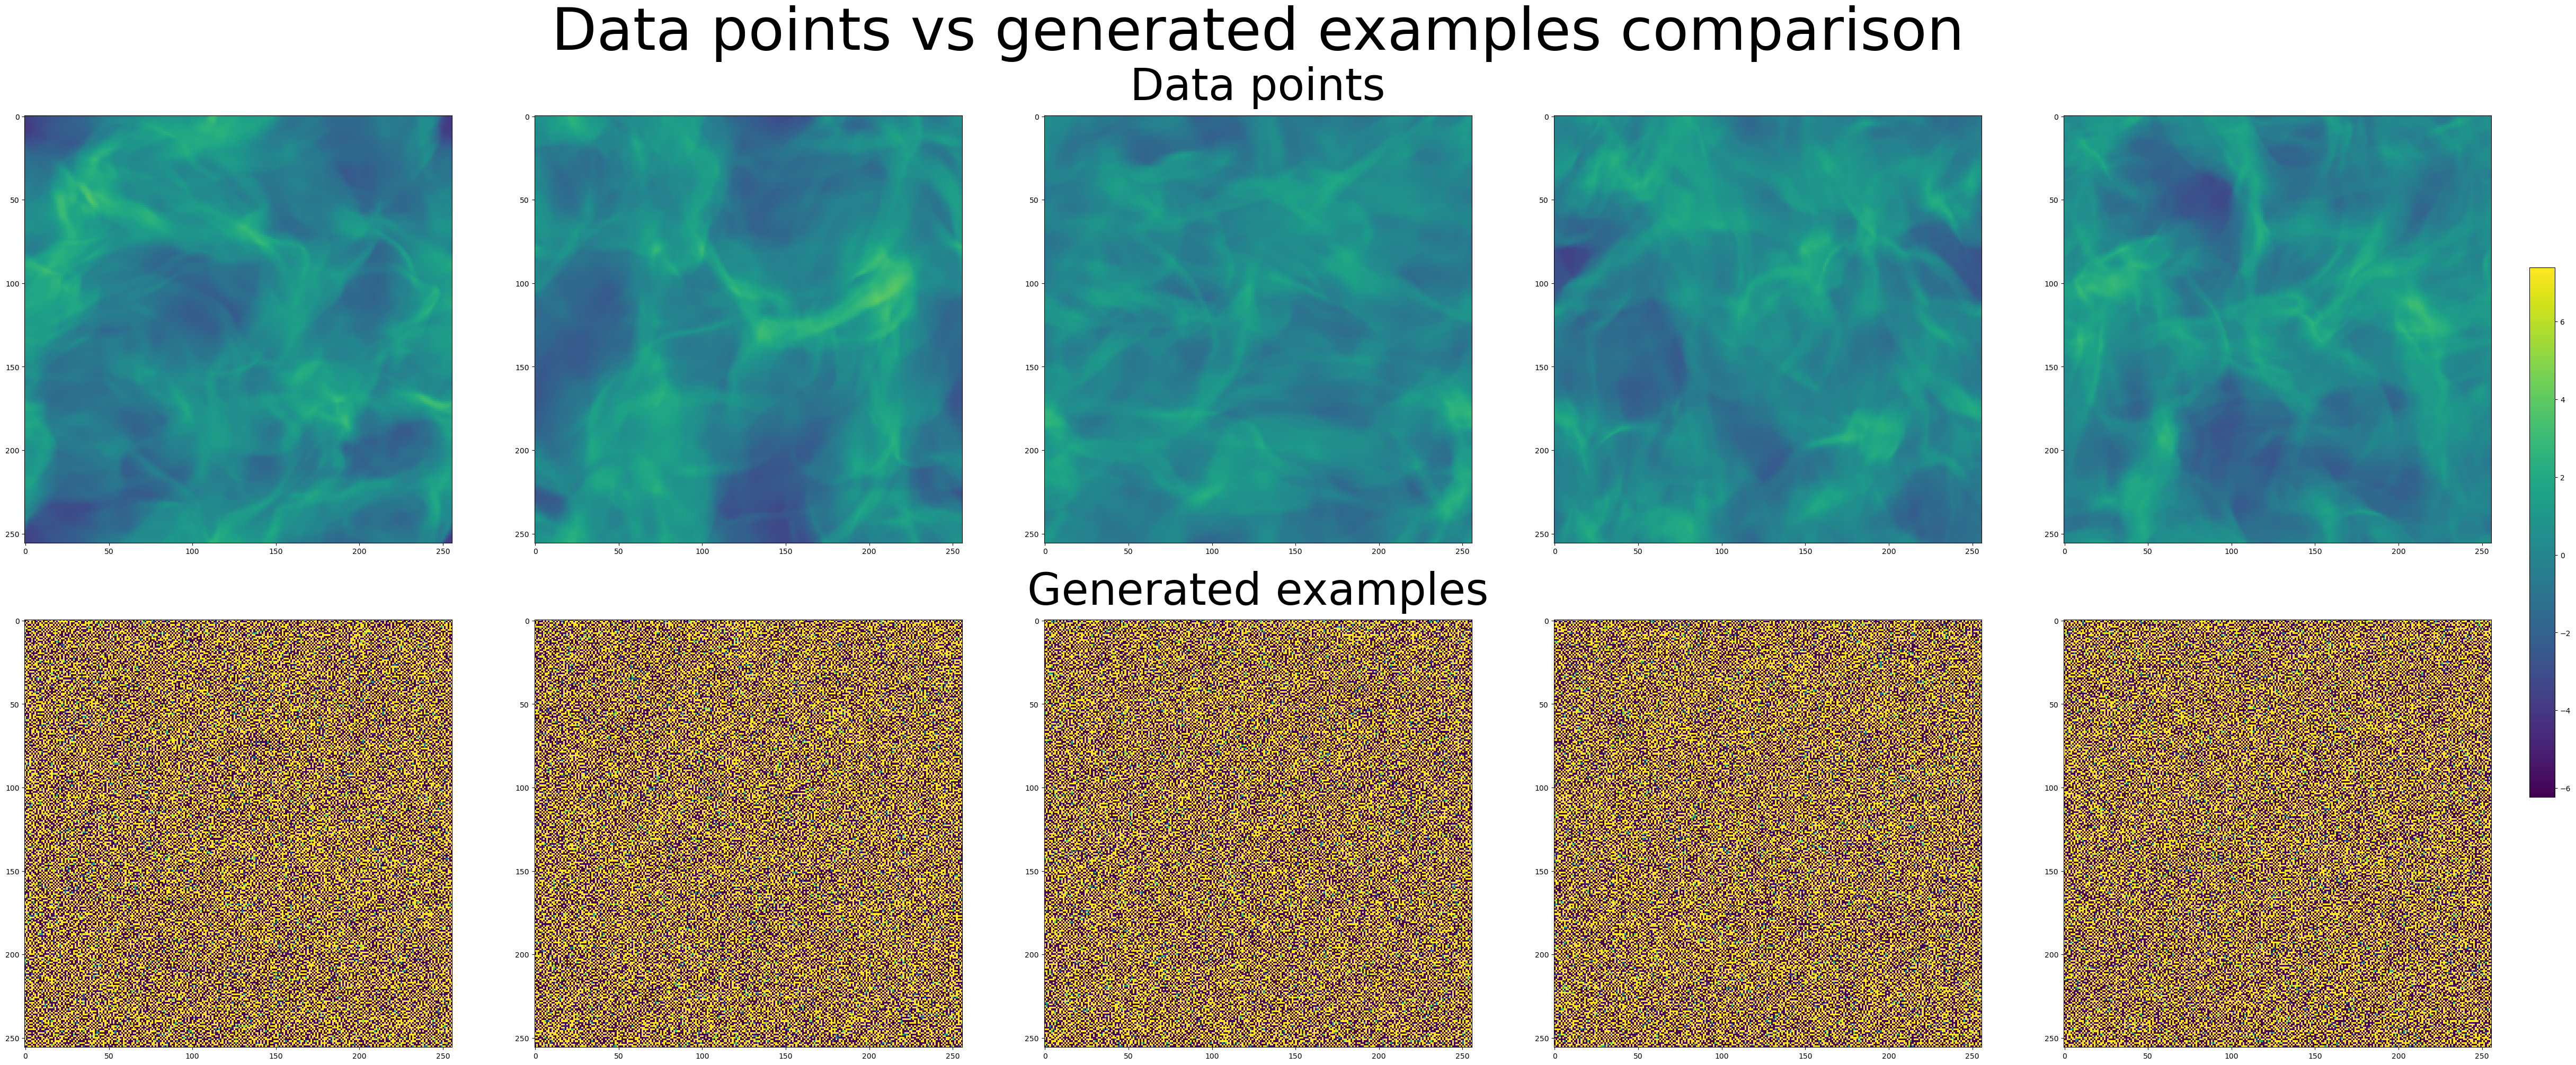

In [16]:
try:
    plot_comparaison_multi_channel(dataset, start, samples, True) #savefile = '/_pdf/results_comparaison_'+MODEL_ID+'_'+str(start//5)+'.pdf'
except:
    print('Shape is probably wrong. Here is what a 1 channel comparaison would give you')
    plot_comparaison_1channel(dataset, start, samples_reduced, amin = amin, amax = amax)

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

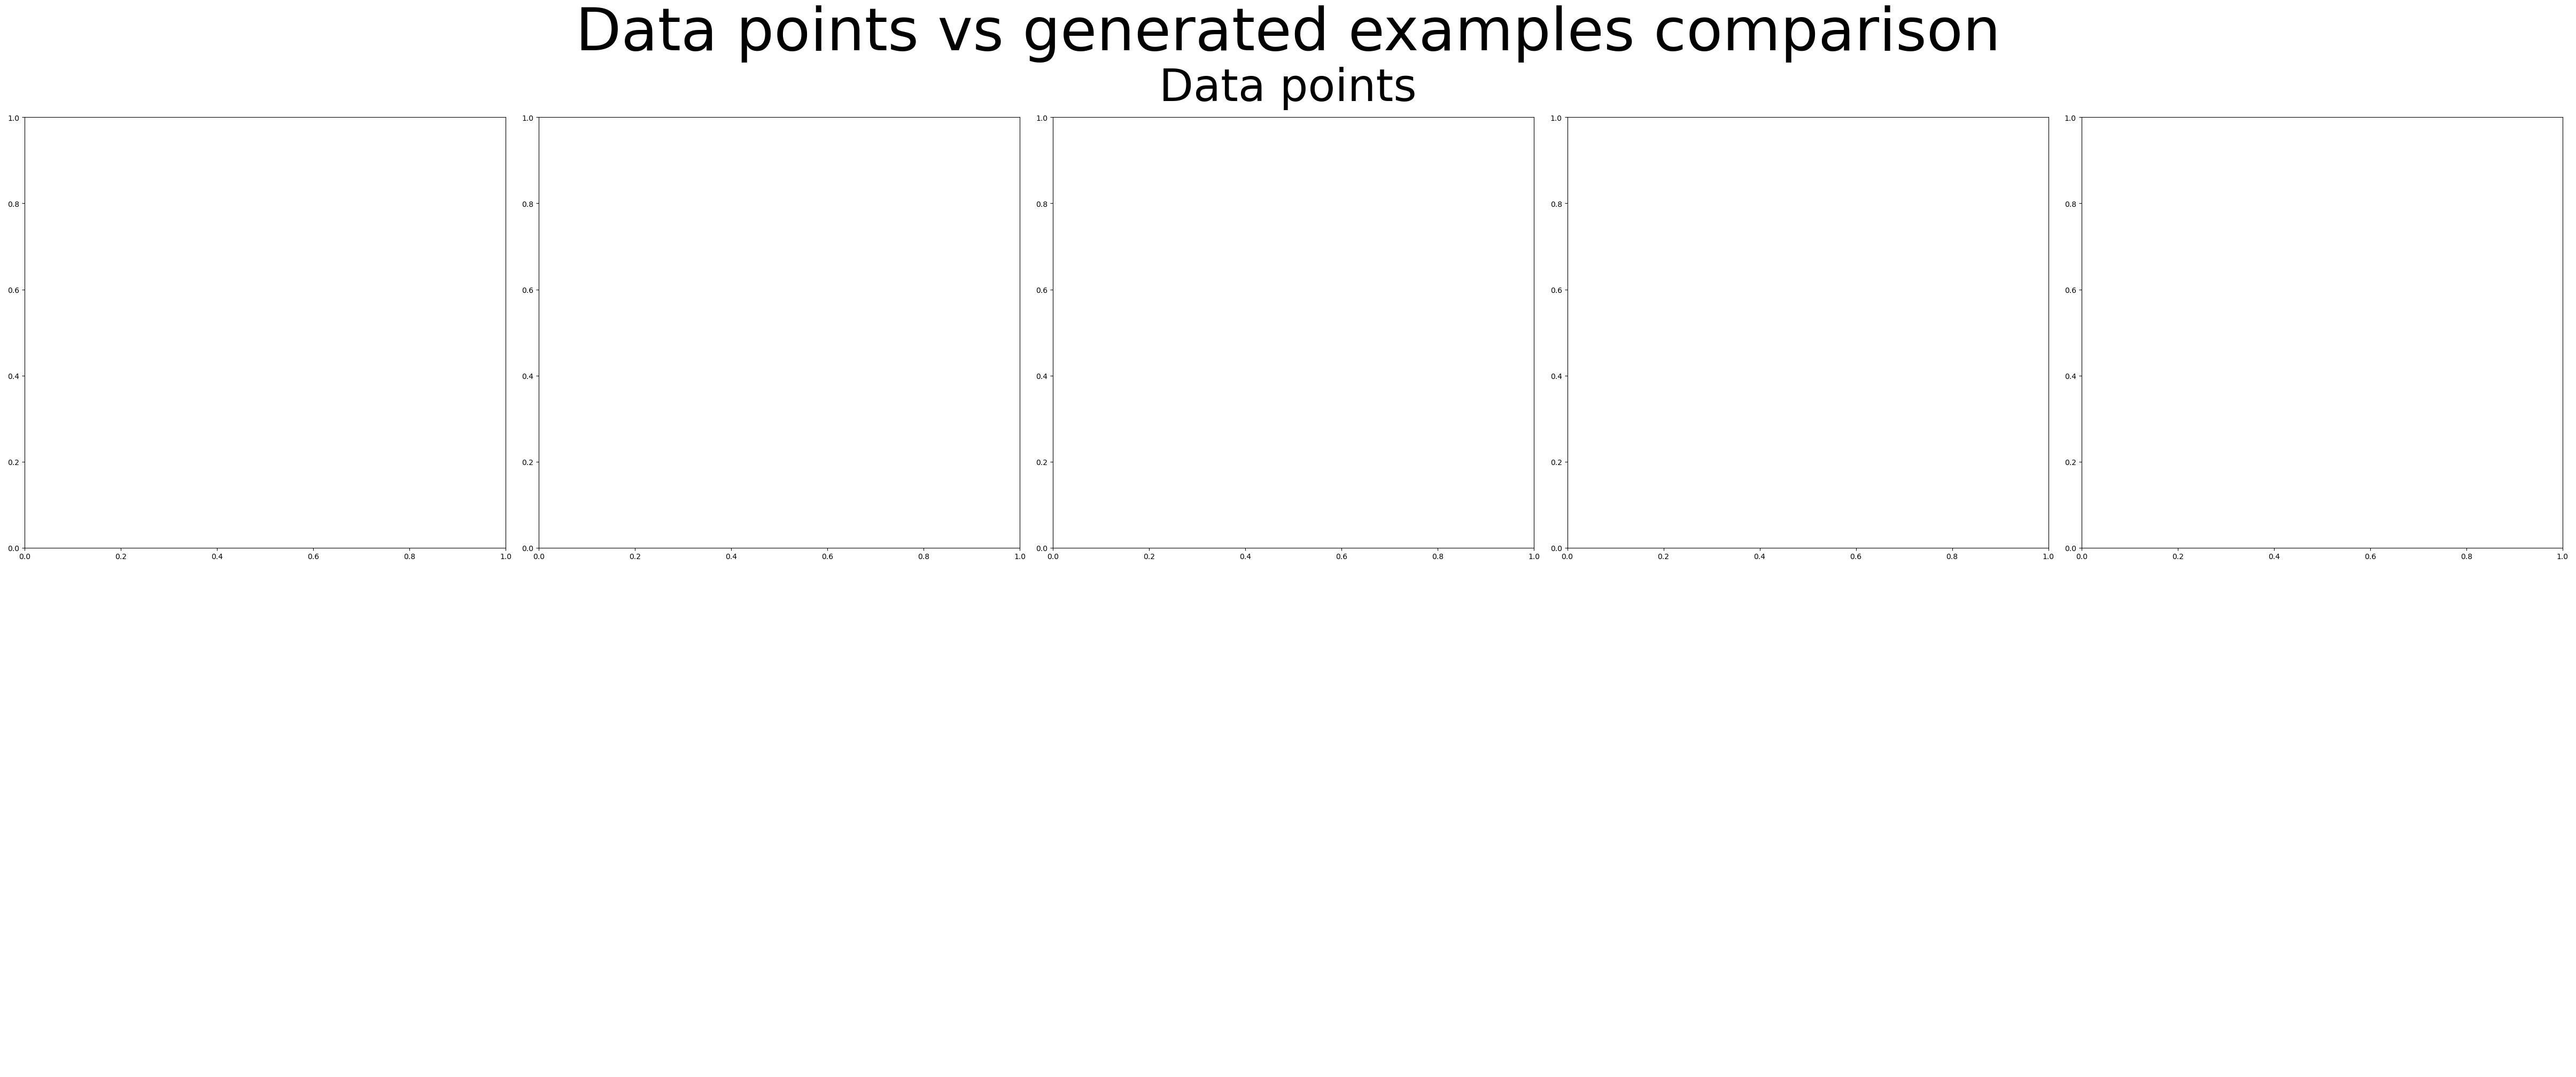

In [17]:
plot_comparaison_multi_channel(dataset, start, samples, False) #savefile = '/_pdf/results_comparaison_color_'+MODEL_ID+'_'+str(start//5)+'.pdf'

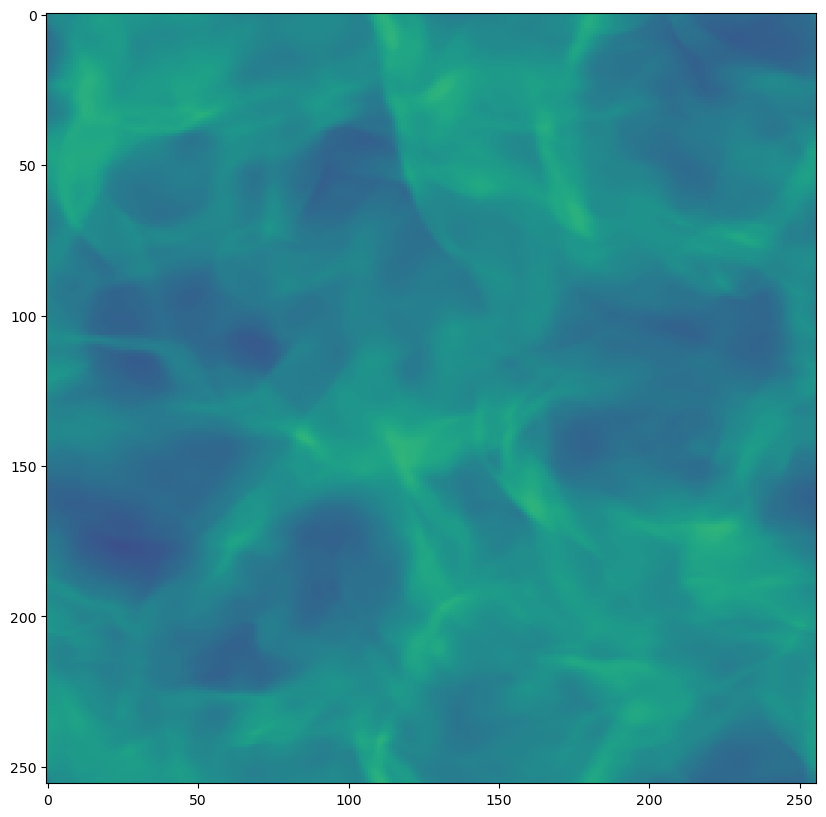

In [ ]:
fig=plt.figure(figsize=(10,10))
plt.imshow(np.sum(np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID,l_results[5]),allow_pickle=True),axis=0),vmin=amin,vmax=amax)
#plt.savefig('/_pdf/sample_'+str(i).zfill(2)+'.pdf')

TypeError: Invalid shape (256,) for image data

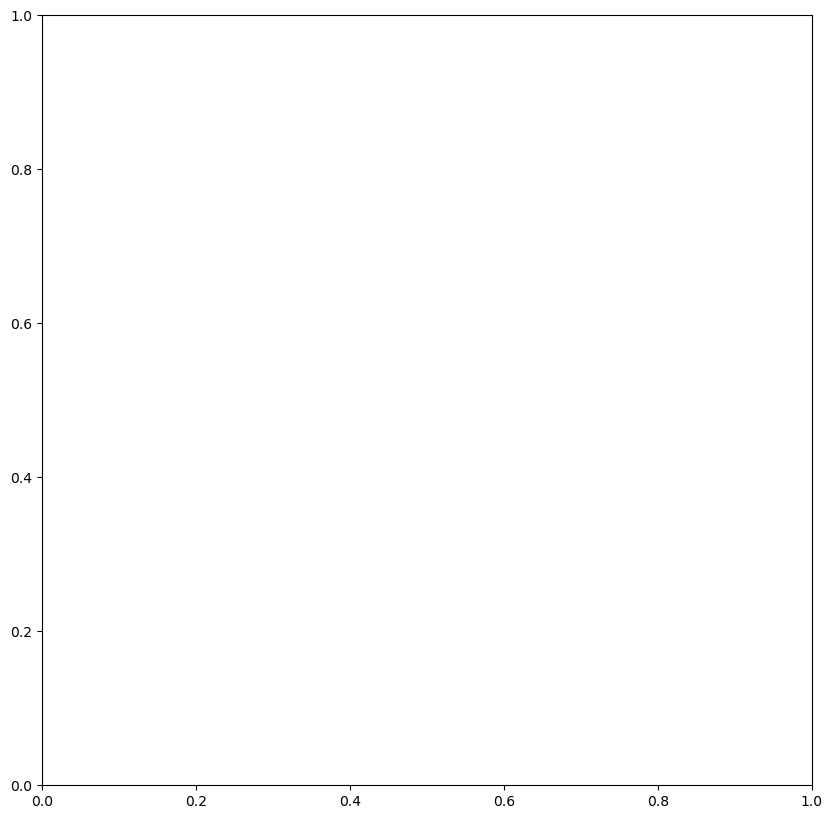

In [ ]:
fig=plt.figure(figsize=(10,10))
plt.imshow(dataset[0][0],vmin=amin,vmax=amax)